<a href="https://colab.research.google.com/github/Nishant-codex/rnn_flip_flops/blob/master/flip_flop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
# import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import tensorflow as tf

import cProfile
%tensorflow_version 1.x magic
import matplotlib.pyplot as plt
np.random.seed(400)
# if(tf.enable_eager_execution()):
#   print('true')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x magic`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
#Hyperparameter
time = 500
bits = 3 
num_steps = 6
batch_size = 200
state_size = 50 
num_classes = 2
learning_rate = 0.01
p = 0.95

def hyp_dict_(time, bits, num_steps , batch_size, state_size, num_classes,
p, learning_rate, ctype):
  return {'time' : time,
'bits' : bits ,
'num_steps' : num_steps,
'batch_size' : batch_size,
'state_size' : state_size ,
'num_classes' : num_classes,
'p': p,
'learning_rate' :learning_rate,
'cell_type':ctype}

hyp_dict = {'time' : 500,
'bits' : 3 ,
'num_steps' : 6,
'batch_size' : 200,
'state_size' : 50 ,
'num_classes' : 2,
'p': 0.95,
'learning_rate' :0.01,
'type':'GRU'
}


In [0]:
def flip_flop(p, bits, time, batch_size, plot=False):

  inputs = []
  outputs= []
  for batch in range(batch_size):
    a = np.random.binomial(1,p,size=[bits, time])
    b = np.random.binomial(1,p,size=[bits, time])
    inp_= a-b
    last = 1
    out_ = np.ones_like(inp_)
    for i in range(bits):
      for m in range(time):
        a = inp_[i,m]
        if a !=0:
          last = a
        out_[i,m] = last
    # if(plot):
    inp_inv = inp_.T
    out_inv = out_.T
    # print(inp_[:,0])
    inputs.append(inp_inv)
    outputs.append(out_inv)
  if(plot):
    plt.plot(inputs[1][:,0])
    plt.plot(outputs[1][:,0])
    plt.xlabel("time")
    plt.ylabel("flip-flop value")
    plt.show()
    plt.plot(inputs[1][:,1])
    plt.plot(outputs[1][:,1])
    plt.xlabel("time")
    plt.ylabel("flip-flop value")
    plt.show()
    plt.plot(inputs[1][:,2])
    plt.plot(outputs[1][:,2])
    plt.xlabel("time")
    plt.ylabel("flip-flop value")
    plt.show()
  return({'inputs':inputs,'outputs':outputs})

def data_batches(num_batches, hyp_dict=hyp_dict):
  batch_list = []
  for i in range(num_batches):
    batch_list.append(flip_flop(hyp_dict['p'],hyp_dict['bits'],hyp_dict['time'],hyp_dict['batch_size']))
  return batch_list
  



In [0]:
# import time
# t1 =time.time()

# print(len(data_batches(200)))
# print(time.time() - t1)

In [0]:
def setup_model(hyp_dict):
  #Hyperparameters
  time = hyp_dict['time']
  bits = hyp_dict['bits']
  num_steps = hyp_dict['num_steps']
  batch_size = hyp_dict['batch_size']
  state_size = hyp_dict['state_size']
  num_classes = hyp_dict['num_classes']
  learning_rate =  hyp_dict['learning_rate']
  cell_type = hyp_dict['type']
  #-----------------------------------------------------------

  x = tf.placeholder(tf.float32, [batch_size, time, bits], name='input_placeholder')
  y = tf.placeholder(tf.float32, [batch_size, time, bits], name='labels_placeholder')

  if cell_type == 'Vanilla':
    cell = tf.contrib.rnn.BasicRNNCell(state_size, reuse=tf.AUTO_REUSE)

  if cell_type == 'GRU':
    cell = tf.contrib.rnn.GRUCell(state_size, reuse=tf.AUTO_REUSE)

  if cell_type == 'LSTM':
    cell = tf.contrib.rnn.BasicLSTMCell(state_size, reuse=tf.AUTO_REUSE)
  
  init_state = cell.zero_state(batch_size, dtype=tf.float32)

  rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_state)

  with tf.variable_scope('losses', reuse=tf.AUTO_REUSE):
      W = tf.get_variable('W', [state_size , bits])
      b = tf.get_variable('b', [bits], initializer=tf.constant_initializer(0.0))

  rnn_outputs_ = tf.reshape(rnn_outputs, [-1, state_size])

  logits = tf.tensordot(rnn_outputs_,W,axes=1) + b
  # predictions = tf.nn.softmax(logits)

  y_as_list =tf.reshape(y, [-1, bits]) #shape is flattened_tensor x bits
  print(y_as_list.shape)
  losses = tf.squared_difference(logits,y_as_list)
  total_loss = tf.reduce_mean(losses)
  train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
  return {'losses':total_loss, 'train_step':train_step, 'hiddens':rnn_outputs,'finalstate':final_state , 'X':x, 'Y':y, 'predict':logits }

In [0]:
# act = setup_model(hyp_dict)

In [0]:
def train_network(num_epochs,hyp_dict, verbose=True, save=True):
  num_epochs = num_epochs
  act = setup_model(hyp_dict)
  data = data_batches(num_epochs, hyp_dict)
  epochs = 0
  training_loss = 0
  hidden = []

  # writer = tf.summary.FileWriter('./graphs')
  saver = tf.train.Saver()


  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    training_losses = []
    for i in range(len(data)):
      ground_truth = data[i]['outputs']
      tr_losses, training_step_, training_state, outputs, predict = \
                  sess.run([act['losses'],
                            act['train_step'],
                            act['finalstate'],
                            act['hiddens'],
                            act['predict']],
                                feed_dict={act['X']:data[i]['inputs'], act['Y']:data[i]['outputs']})
      training_loss += tr_losses

      if verbose:
          print("Average training loss for Epoch", epochs, ":", training_loss/100)
      training_losses.append(training_loss)
      training_loss = 0
      if epochs == 0:
        hidden.append(outputs)
      epochs +=1
    hidden.append(outputs)
    if(save):
      saver.save(sess, save)
  return training_losses, hidden, predict, ground_truth

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(100000, 3)
Average training loss for Epoch 0 : 0.010235071182250977
Average training loss for Epoch 1 

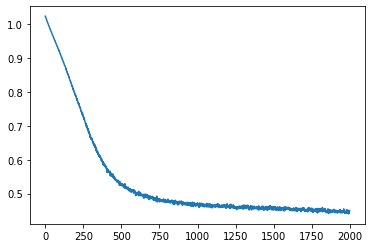

In [8]:
training_losses, hidden ,predict, ground= train_network(2000,hyp_dict,num_steps,save='saver/GRU_2000_epochs')
plt.plot(training_losses)
plt.show()

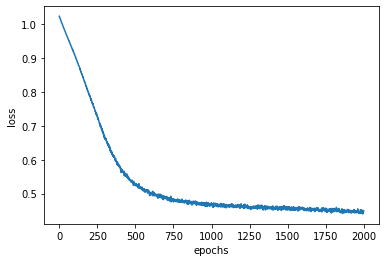

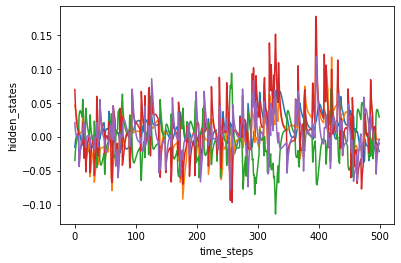

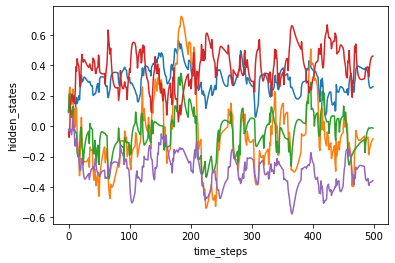

In [9]:
plt.plot(training_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.plot(hidden[0][199,:,:5])
plt.xlabel('time_steps')
plt.ylabel('hidden_states')
plt.show()
plt.plot(hidden[1][199,:,:5])
plt.xlabel('time_steps')
plt.ylabel('hidden_states')
plt.show()

[0.22474465 0.00857912 0.00372688]


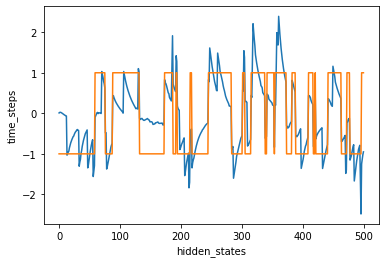

In [16]:
new_p=np.reshape(predict,[200,500,3])
plt.plot(predict[:500,1])
plt.plot(np.reshape(ground,[-1,3])[:500,1])
plt.xlabel('hidden_states')
plt.ylabel('time_steps')

print(predict[0])